# Advantage Actor-Critic (A2C) on mujoco spider 


In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
print(tf.__version__)
tf.disable_eager_execution()

2.6.0


In [2]:
import numpy as np
import gym
import scipy
from SpiderEnv.SpiderEnv_many import SpiderEnv

critic_learning_rate = 1e-3
actor_learning_rate = 1e-4
epochs_number = 3000000
batch_size = 3000
replay_buffer_size = batch_size

discount_factor = 0.98 # aka gamma
lambda_factor = 0.96

angle_normalization = 135

# Put any gym environment name here (i.e. LunarLanderContinuous-v2) 
# https://gym.openai.com/envs/#classic_control
# Don't forget to change Actor's model to discrete or continuous accordingly
env_name = 'SpiderEnv_many'

algorithm_name = 'A2C-GAE'

# Vectorized environment size
environments_count = 20

In [3]:
def create_environment():
    if env_name == 'SpiderEnv_many':
        return SpiderEnv()
    else:
        return gym.make(env_name)

env = create_environment()
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]

In [4]:
print(observation_space)

832


## Define model architecture

The following is the implementation of Actor(policy) and Critic(value) models. Critic is a function $V:Observations\rightarrow {Values}$.
Actor is a function $\pi_\theta:Observations\rightarrow Actions$. There are two variants of Actor:  
   * for discrete control tasks, $Actions \subset \{1, 2, ..., n\}$ 
   * for continuous control tasks, $Actions\subset \mathbb{R}^n$ 
   
Note: actor has stocastic output which allows exploration.

[Derivation of gaussian loglikelihood](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#stochastic-policies)   
It is used with policies with continuous output.

In [5]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [6]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', 
                                  initializer=-0.5 * np.ones(action_space, 
                                                             dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std

        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)
        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), 
                                    axis=1)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)


class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=critic_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

# Replace ActorNetworkContinuous with ActorNetworkDiscrete for discrete envs
actor = ActorNetworkContinuous()
critic = CriticNetwork()

/home/to4i/micromamba/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/to4i/micromamba/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Disallow tensorflow usage of GPU. Works faster on small models.

In [7]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

2021-12-19 14:17:04.963262: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-19 14:17:04.963916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/to4i/.mujoco/mujoco210/bin
2021-12-19 14:17:04.963934: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-19 14:17:04.963959: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (to4i-w): /proc/driver/nvidia/version does not exist


## Create environments vector

In [8]:
# Vectorized environments with gym-like interface
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

def make_env(env_id, seed):
    def _f():
        env = create_environment()
        env.reset()
        
        # Desync environments
        for i in range(int(200 * seed // environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]

# Can be switched to SubprocVecEnv to parallelize on cores 
# (for computationally heavy envs)
envs = DummyVecEnv(envs)

# Define batch generator

In [9]:
# Source: 
# https://github.com/openai/spinningup/blob/master/spinup/algos/ppo/core.py

def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

Advantage estimation from [GAE paper](https://arxiv.org/pdf/1506.02438.pdf)

In [10]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    return advantage, values

Batch generator samples **batch_size** timestamps from **replay_buffer**.   
Array **replay_buffer** consists of following np.arrays **[state, action, advantage, discounted reward-to-go]**.

In [11]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 
                   'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            # Here policy acts in environments. Note that it chooses actions for all
            # environments in one batch, therefore expensive sess.run is called once.
            actions = sess.run(actor.action_op, 
                               feed_dict={actor.state_ph: observations})
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions * angle_normalization)
            observations /= angle_normalization
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                # Regular python-like append
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) 
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!! This makes sampling inefficient!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, 
                                                          coef=discount_factor)

                rollout = np.hstack((rollouts[i], 
                                     np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        # Shuffle before yield to become closer to i.i.d.
        np.random.shuffle(replay_buffer)
        
        # Truncate replay_buffer to get the most relevant feedback from environment
        replay_buffer = replay_buffer[:replay_buffer_size]
        yield replay_buffer[:batch_size], history

# Make a test yield
a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

/tmp/ipykernel_12143/1673424838.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  time_point = np.array(list(zip(observations_old, actions, rewards)))


array([[array([ 6.66666667e-01, -2.04476364e-01,  6.66666667e-01,  6.66666667e-01,
       -4.89452729e-01, -2.04372943e-01, -2.43952066e-01, -6.66666667e-01,
       -3.94522179e-01, -6.66666667e-01, -5.46582370e-01,  0.00000000e+00,
        0.00000000e+00, -4.27136202e-01,  0.00000000e+00, -2.41818972e-01,
        0.00000000e+00, -6.66666667e-01,  7.40740741e-03,  0.00000000e+00,
        7.40740741e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.40142068e-03, -1.13733706e-04,  2.67656692e-04, -6.38818397e-05,
        7.37098770e-03, -1.35401615e-04,  2.57374947e-04, -6.73535021e-04,
        7.25130571e-03, -1.32979651e-03,  3.63266856e-04, -6.22839048e-04,
        6.16215221e-03, -4.04693382e-03,  5.77017922e-04, -4.32367443e-04,
        7.40169628e-03, -1.11378851e-04,  2.68645141e-04,  1.11734745e-06,
        7.30205942e-03,  1.21550043e-03,  2.64505141e-04, -4.69945823e-05,
        5.96244339e-03,  4.38711544e-03,  2.14638497e-04, -1.61560441e-04,
        7.2883934

## Agent training

In [12]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}
max_value = 0

In [13]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [14]:
from tqdm import tqdm_notebook
import pickle

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']

    # Pickle model if its the best so far
    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-{algorithm_name}-reward({value}).ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value
        
    if epoch % 1000 == 0:
        with open(f'models/{env_name}-{algorithm_name}-reward({value}).history', 'wb') as f:
            pickle.dump(history, f)
            
    # Remainder: batch item consists of [state, action, advantage, discounted reward-to-go]
    # Train actor
    _, actor_loss = sess.run([actor.update_op, actor.loss], 
                             feed_dict={actor.state_ph: np.array(batch[:, 0].tolist()),
                                        actor.action_ph: np.array(batch[:, 1].tolist()),
                                        actor.weight_ph: batch[:, 2]})
    # Train critic
    for j in range(10):
        _, critic_loss = sess.run([critic.update_op, critic.loss], 
                                  feed_dict={critic.state_ph: np.array(batch[:, 0].tolist()),
                                             critic.value_ph: batch[:, 3]})
    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)


Charging generators


/tmp/ipykernel_12143/1673424838.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  time_point = np.array(list(zip(observations_old, actions, rewards)))
/tmp/ipykernel_12143/768025288.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs_number)):


  0%|          | 0/3000000 [00:00<?, ?it/s]

Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(88).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(274).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(452).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(548).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(984).ckpt
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(986).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1035).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1104).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1295).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1305).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1334).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1360).ckpt
Model saved in path: ./models/SpiderEnv_many-A2C-GAE-reward(1399).ckpt


KeyboardInterrupt: 

## Plot results

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'SpiderEnv_many A2C-GAE')

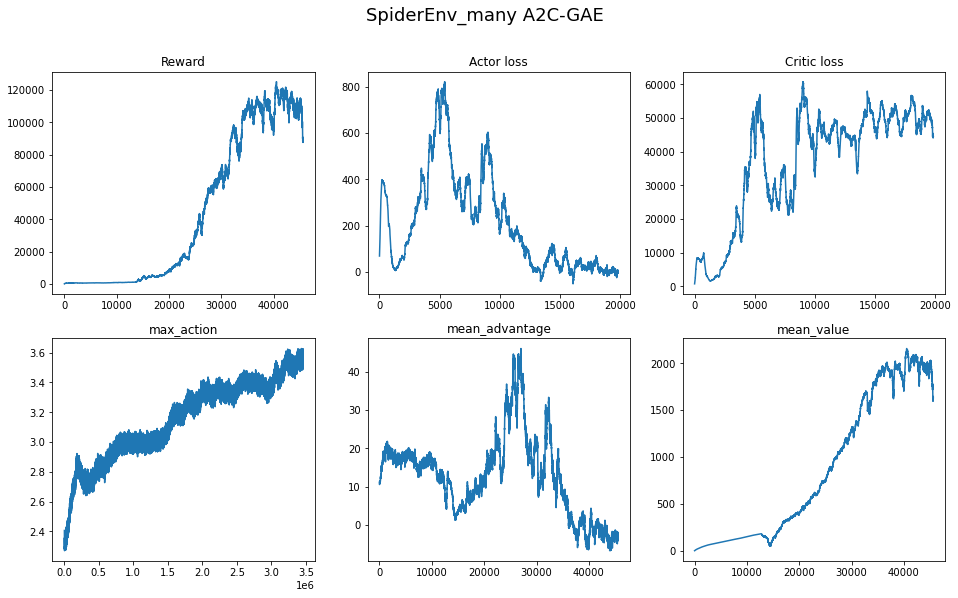

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name + ' ' + algorithm_name, fontsize=18)

# plt.savefig(f'logs/{env_name}_{algorithm_name}')

## Demo

In [17]:
observations = env.reset()
rewards_sum = 0

while True:
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})

    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0] * angle_normalization)
    observations = observations.astype(np.float32) / angle_normalization
    rewards_sum += rewards

    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

Creating window glfw


SystemExit: 0

/home/to4i/micromamba/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
